In [393]:
# Adam Lawrence
# CS555 - Homework 4
# An investigation in quadratic shape functions in 2D triangular meshes
# This source code was adapted from the code supplied by Professor Olson

In [394]:
import numpy as np
from scipy import sparse
from scipy.sparse import linalg as sla
import matplotlib.pyplot as plt
from matplotlib import tri

import plotly.offline as py
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = 'iframe'

In [395]:
!wget https://raw.githubusercontent.com/lukeolson/cs555-demos/main/mesh.e
!wget https://raw.githubusercontent.com/lukeolson/cs555-demos/main/mesh.v

In [396]:
def generate_quadratic(V, E, return_edges=False):
    """Generate a quadratic element list by adding midpoints to each edge.
    Parameters
    ----------
    V : ndarray
        nv x 2 list of coordinates
    E : ndarray
        ne x 3 list of vertices
    return_edges : bool
        indicate whether list of the refined edges is returned
    Returns
    -------
    V2 : ndarray
        nv2 x 2 list of coordinates
    E2 : ndarray
        ne2 x 6 list of vertices
    Edges : ndarray
        ned x 2 list of edges where the midpoint is generated
    Notes
    -----
        - midpoints are introduced and globally numbered at the end of the vertex list
        - the element list includes the new list beteen v0-v1, v1-v2, and v2-v0
    Examples
    --------
    >>> import numpy as np
    >>> from pyamg.gallery import fem
    >>> V = np.array([[0.,0.], [1.,0.], [0.,1.], [1.,1.]])
    >>> E = np.array([[0,1,2], [2,3,1]])
    >>> V2, E2 = fem.generate_quadratic(V, E)
    >>> print(V2)
    [[0.  0. ]
     [1.  0. ]
     [0.  1. ]
     [1.  1. ]
     [0.5 0. ]
     [0.5 0.5]
     [0.  0.5]
     [0.5 1. ]
     [1.  0.5]]
    >>> print(E2)
    [[0 1 2 4 5 6]
     [2 3 1 7 8 5]]
    """
    if not isinstance(V, np.ndarray) or not isinstance(E, np.ndarray):
        raise ValueError('V and E must be ndarray')

    if V.shape[1] != 2 or E.shape[1] != 3:
        raise ValueError('V should be nv x 2 and E should be ne x 3')

    ne = E.shape[0]

    # make a vertext-to-vertex graph
    ID = np.kron(np.arange(0, ne), np.ones((3,), dtype=int))
    G = sparse.coo_matrix((np.ones((ne*3,), dtype=int), (E.ravel(), ID,)))
    V2V = G * G.T

    # from the vertex graph, get the edges and create new midpoints
    V2Vmid = sparse.tril(V2V, -1)
    Edges = np.vstack((V2Vmid.row, V2Vmid.col)).T
    Vmid = (V[Edges[:, 0], :] + V[Edges[:, 1], :]) / 2.0
    V = np.vstack((V, Vmid))

    # enumerate the new midpoints for the edges
    # V2Vmid[i,j] will have the new number of the midpoint between i and j
    maxindex = E.max() + 1
    newID = maxindex + np.arange(Edges.shape[0])
    V2Vmid.data = newID
    V2Vmid = V2Vmid + V2Vmid.T

    # from the midpoints, extend E
    E = np.hstack((E, np.zeros((E.shape[0], 3), dtype=int)))
    E[:, 3] = V2Vmid[E[:, 0], E[:, 1]]
    E[:, 4] = V2Vmid[E[:, 1], E[:, 2]]
    E[:, 5] = V2Vmid[E[:, 2], E[:, 0]]

    if return_edges:
        return V, E, Edges

    return V, E

In [397]:
# This function was fixed from the original supplied code
def applybc(A, b, V, E):
    """
    Applied zero Dirichlet conditions everywhere

    Returns
    -------
    A : sparse matrix
        Modified, assembled sparse matrix
    b : ndarray
        Modified, assembled right-hand side
    """
    # Professor forgot to do this in his code
    X = V[:, 0]
    Y = V[:, 1]

    tol = 1e-14

    id1 = np.where(abs(Y + 1) < tol)[0]
    id2 = np.where(abs(Y - 1) < tol)[0]
    id3 = np.where(abs(X + 1) < tol)[0]
    id4 = np.where(abs(X - 1) < tol)[0]
    I = np.vstack((id1, id2, id3, id4)).ravel()
    I = np.unique(I)

    # Set all boundary nodes to 0, Professor forgot to do this in his code
    b[I] = 0.0

    Dflag = np.zeros(A.shape[0], dtype=bool)
    Dflag[I] = True

    for k, (i, j) in enumerate(zip(A.row, A.col)):
        if Dflag[i] or Dflag[j]:
            if i == j:
                A.data[k] = 1.0
            else:
                A.data[k] = 0.0


    return A, b


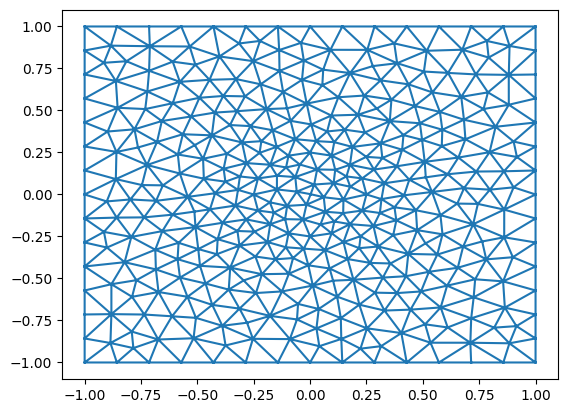

In [398]:
V = np.loadtxt('mesh.v')
E = np.loadtxt('mesh.e', dtype=int)

V2, E2, edges2 = generate_quadratic(V, E, return_edges=True)

X, Y = V2[:, 0], V2[:, 1]
plt.triplot(X, Y, E2[:, :3])

In [399]:
def kappa(x, y):
    if np.sqrt(x**2 + y**2) <= 0.25:
        return 100.0
    return 2.0

def f(x, y):
    if np.sqrt(x**2 + y**2) <= 0.25:
        return 100.0
    return 0.0

In [400]:
ne = E2.shape[0]

# allocate sparse matrix arrays
m = 6  # Updated for quadratics
AA = np.zeros((ne, m**2))
IA = np.zeros((ne, m**2), dtype=int)
JA = np.zeros((ne, m**2), dtype=int)
bb = np.zeros((ne, m))
ib = np.zeros((ne, m), dtype=int)
jb = np.zeros((ne, m), dtype=int)

# Assemble A and b
for ei in range(0, ne):
    # Step 1: set the vertices and indices
    K = E2[ei, :]
    x0, y0 = X[K[0]], Y[K[0]]
    x1, y1 = X[K[1]], Y[K[1]]
    x2, y2 = X[K[2]], Y[K[2]]

    # Step 2: compute the Jacobian, inv, and det
    J = np.array([[x1 - x0, x2 - x0],
                  [y1 - y0, y2 - y0]])
    invJ = np.linalg.inv(J.T)
    detJ = np.linalg.det(J)

    # Step 3a: set up quadrature nodes in the triangle
    ww = np.array([0.44676317935602256, 0.44676317935602256, 0.44676317935602256,
                   0.21990348731064327, 0.21990348731064327, 0.21990348731064327])
    xy = np.array([[-0.10810301816807008, -0.78379396366385990],
                   [-0.10810301816806966, -0.10810301816807061],
                   [-0.78379396366386020, -0.10810301816806944],
                   [-0.81684757298045740, -0.81684757298045920],
                   [0.63369514596091700, -0.81684757298045810],
                   [-0.81684757298045870, 0.63369514596091750]])
    xx, yy = (xy[:, 0] + 1) / 2, (xy[:, 1] + 1) / 2
    ww *= 0.5

    # Step 3b: set element matrix and right-hand side to zero
    Aelem = np.zeros((m, m))
    belem = np.zeros((m,))

    # Step 3c: loop over each quadrature weight
    for w, x, y in zip(ww, xx, yy):
        # Step 3d: set quadratic basis at the quadrature points
        basis = np.array([
            (1 - x - y) * (1 - 2 * x - 2 * y), # N1
            x * (2 * x - 1), # N2
            y * (2 * y - 1), # N3
            4 * x * (1 - x - y), # N4
            4 * x * y, # N5
            4 * y * (1 - x - y) # N6
        ])

        dbasis = np.array([
            [
                -3 + 4 * x + 4 * y,  # d/dx of N1
                4 * x - 1,           # d/dx of N2
                0,                   # d/dx of N3
                4 - 8 * x - 4 * y,   # d/dx of N4
                4 * y,               # d/dx of N5
                -4 * y               # d/dx of N6
            ],
            [
                -3 + 4 * x + 4 * y,  # d/dy of N1
                0,                   # d/dy of N2
                4 * y - 1,           # d/dy of N3
                -4 * x,              # d/dy of N4
                4 * x,               # d/dy of N5
                4 - 4 * x - 8 * y    # d/dy of N6
            ]
        ])

        # Step 4: construct J^{-T} dphi
        dphi = invJ.dot(dbasis)

        # Step 5: add to element matrix
        xt, yt = J.dot(np.array([x, y])) + np.array([x0, y0])
        kappaelem = kappa(xt, yt)
        Aelem += (detJ / 2) * w * kappaelem * dphi.T @ dphi

        # Step 6: add to element rhs
        belem += (detJ / 2) * w * f(xt, yt) * basis

    # Step 7
    AA[ei, :] = Aelem.ravel()
    IA[ei, :] = np.repeat(K[np.arange(m)], m)
    JA[ei, :] = np.tile(K[np.arange(m)], m)
    bb[ei, :] = belem.ravel()
    ib[ei, :] = K[np.arange(m)]
    jb[ei, :] = 0

# convert matrices
A = sparse.coo_matrix((AA.ravel(), (IA.ravel(), JA.ravel())))
A.sum_duplicates()
b = sparse.coo_matrix((bb.ravel(), (ib.ravel(), jb.ravel()))).toarray().ravel()


In [401]:
A, b = applybc(A, b, V2, E2)

In [402]:
u = sla.spsolve(A.tocsr(), b)  # see CS556

In [403]:
fig = ff.create_trisurf(x=X, y=Y, z=u,
                        simplices=E)
py.iplot(fig, filename='surf')
fig.show(renderer="colab")

# Test your code with a specific `kappa` and `f` to verify correctness and convergence rate.

In [404]:
def kappa(x, y):
    return 1.0

def f(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y) # Inferred from uexact

def uexact(x, y):
    return (np.sin(np.pi * x) * np.sin(np.pi * y)) / (2 * np.pi ** 2)

(373, 2) (688, 3)
Refinement: 0, h: 1.1648e-01, L2 Error: 3.4592e-05
(1433, 2) (2752, 3)
Refinement: 1, h: 5.8239e-02, L2 Error: 4.2459e-06
(5617, 2) (11008, 3)
Refinement: 2, h: 2.9120e-02, L2 Error: 5.2890e-07


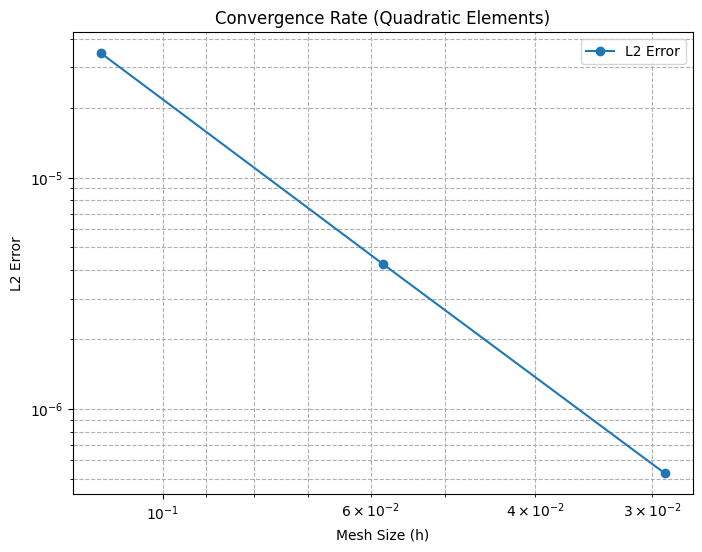


Convergence Rates (L2):
  0 -> 1: 3.03
  1 -> 2: 3.01


In [405]:
l2_errors = []
h_values = []

for ref in range(0, 3):

    V_base = np.loadtxt('mesh.v')
    E_base = np.loadtxt('mesh.e', dtype=int)

    # Refine mesh
    t = tri.Triangulation(V_base[:, 0], V_base[:, 1], E_base)
    mesh = tri.UniformTriRefiner(t)
    t = mesh.refine_triangulation(subdiv=ref)
    V = np.vstack([t.x, t.y]).T
    E = t.triangles
    print(V.shape, E.shape)

    # Estimate mesh size h (used for convergence analysis)
    edge_lengths = []
    for el in E:
        p0, p1, p2 = V[el[0]], V[el[1]], V[el[2]]
        edge_lengths.append(np.linalg.norm(p1 - p0))
        edge_lengths.append(np.linalg.norm(p2 - p1))
        edge_lengths.append(np.linalg.norm(p0 - p2))
    h = np.mean(edge_lengths)
    h_values.append(h)

    V2, E2, edges2 = generate_quadratic(V, E, return_edges=True)
    X, Y = V2[:, 0], V2[:, 1]


    # Quadrature weights and reference coordinates
    ww = np.array([0.44676317935602256, 0.44676317935602256, 0.44676317935602256,
                   0.21990348731064327, 0.21990348731064327, 0.21990348731064327])
    xy = np.array([[-0.10810301816807008, -0.78379396366385990],
                   [-0.10810301816806966, -0.10810301816807061],
                   [-0.78379396366386020, -0.10810301816806944],
                   [-0.81684757298045740, -0.81684757298045920],
                   [0.63369514596091700, -0.81684757298045810],
                   [-0.81684757298045870, 0.63369514596091750]])
    xx = (xy[:, 0] + 1) / 2
    yy = (xy[:, 1] + 1) / 2
    ww = ww * 0.5

    ne = E2.shape[0]
    nv = V2.shape[0]
    m = 6

    AA = np.zeros((ne, m ** 2))
    IA = np.zeros((ne, m ** 2), dtype=int)
    JA = np.zeros((ne, m ** 2), dtype=int)
    bb = np.zeros((ne, m))
    ib = np.zeros((ne, m), dtype=int)
    jb = np.zeros((ne, m), dtype=int)

    # Assemble A and b
    for ei in range(ne):
        K = E2[ei, :]

        x0, y0 = X[K[0]], Y[K[0]]
        x1, y1 = X[K[1]], Y[K[1]]
        x2, y2 = X[K[2]], Y[K[2]]

        J = np.array([[x1 - x0, x2 - x0],
                      [y1 - y0, y2 - y0]])
        invJ = np.linalg.inv(J.T)
        detJ = np.linalg.det(J)

        Aelem = np.zeros((m, m))
        belem = np.zeros((m,))

        for w, xi, yi in zip(ww, xx, yy):
            basis = np.array([
                (1 - xi - yi) * (1 - 2 * xi - 2 * yi),
                xi * (2 * xi - 1),
                yi * (2 * yi - 1),
                4 * xi * (1 - xi - yi),
                4 * xi * yi,
                4 * yi * (1 - xi - yi)
            ])

            dbasis = np.array([
                [
                    -3 + 4 * xi + 4 * yi,
                    4 * xi - 1,
                    0,
                    4 - 8 * xi - 4 * yi,
                    4 * yi,
                    -4 * yi
                ],
                [
                    -3 + 4 * xi + 4 * yi,
                    0,
                    4 * yi - 1,
                    -4 * xi,
                    4 * xi,
                    4 - 4 * xi - 8 * yi
                ]
            ])

            dphi = invJ @ dbasis

            xt, yt = J @ np.array([xi, yi]) + np.array([x0, y0])
            kappaelem = kappa(xt, yt)
            Aelem += (detJ / 2) * w * kappaelem * dphi.T @ dphi

            belem += (detJ / 2) * w * f(xt, yt) * basis

        AA[ei, :] = Aelem.ravel()
        IA[ei, :] = np.repeat(K[np.arange(m)], m)
        JA[ei, :] = np.tile(K[np.arange(m)], m)
        bb[ei, :] = belem.ravel()
        ib[ei, :] = K[np.arange(m)]
        jb[ei, :] = 0

    A = sparse.coo_matrix((AA.ravel(), (IA.ravel(), JA.ravel())), shape=(nv, nv))
    A.sum_duplicates()
    b = sparse.coo_matrix((bb.ravel(), (ib.ravel(), jb.ravel())), shape=(nv, 1)).toarray().ravel()

    # Apply Boundary Conditions
    A, b = applybc(A, b, V2, E2)

    u = sla.spsolve(A.tocsr(), b)

    # Compute L2 Error using the solved solution
    l2_err_sq = 0.0
    for ei in range(ne):
        K = E2[ei, :]
        x0, y0 = X[K[0]], Y[K[0]]
        x1, y1 = X[K[1]], Y[K[1]]
        x2, y2 = X[K[2]], Y[K[2]]
        J = np.array([[x1 - x0, x2 - x0],
                      [y1 - y0, y2 - y0]])
        detJ = np.linalg.det(J)
        for w, xi, yi in zip(ww, xx, yy):
            xt, yt = J @ np.array([xi, yi]) + np.array([x0, y0])
            basis = np.array([
                (1 - xi - yi) * (1 - 2 * xi - 2 * yi),
                xi * (2 * xi - 1),
                yi * (2 * yi - 1),
                4 * xi * (1 - xi - yi),
                4 * xi * yi,
                4 * yi * (1 - xi - yi)
            ])
            u_elem = u[K]
            u_h_q = basis @ u_elem
            u_exact_q = uexact(xt, yt)
            l2_err_sq += (detJ / 2) * w * (u_h_q - u_exact_q) ** 2

    l2_err = np.sqrt(l2_err_sq)
    l2_errors.append(l2_err)
    print(f"Refinement: {ref}, h: {h:.4e}, L2 Error: {l2_err:.4e}")

# Plot error vs. mesh size.
plt.figure(figsize=(8, 6))
plt.loglog(h_values, l2_errors, 'o-', label='L2 Error')
plt.xlabel('Mesh Size (h)')
plt.ylabel('L2 Error')
plt.title('Convergence Rate (Quadratic Elements)')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.gca().invert_xaxis()
plt.savefig("convergence_rate.png", dpi=400)
plt.show()

# Calculate approximate convergence rates
if len(h_values) > 1:
    rates = np.log(np.array(l2_errors[:-1]) / np.array(l2_errors[1:])) / \
            np.log(np.array(h_values[:-1]) / np.array(h_values[1:]))
    print("\nConvergence Rates (L2):")
    for i, rate in enumerate(rates):
        print(f"  {i} -> {i + 1}: {rate:.2f}")
